In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 6)

In [11]:
path_dataset = '/home/magody/programming/python/data_science/data/restaurant'
file = 'restaurant-1-orders.csv'
# header: Order Number,Order Date,Item Name,Quantity,Product Price,Total products
df_orders = pd.concat([
    pd.read_csv(f"{path_dataset}/restaurant-1-orders.csv"),
    pd.read_csv(f"{path_dataset}/restaurant-2-orders.csv")
    ], axis=0)

# The data is already cleaned
print("Original dataframe")
df_orders.head()

Original dataframe


,Order ID,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [12]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194001 entries, 0 to 119182
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Order ID        194001 non-null  int64  
 1   Order Date      194001 non-null  object 
 2   Item Name       194001 non-null  object 
 3   Quantity        194001 non-null  int64  
 4   Product Price   194001 non-null  float64
 5   Total products  194001 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 10.4+ MB


In [27]:
items_names = list(df_orders["Item Name"].unique())
items_names.sort()
with open("names.txt", "w+") as f_in:
    f_in.writelines(map(lambda s: s+"\n", items_names))
    del items_names

To simplify things. We can summarize items like Korma, Korma - Chicken, Korma - Chicken Tikka,etc. As the same

In [44]:
df_orders["item"] = df_orders["Item Name"].apply(lambda s: s.split(" ")[0].lower())
df_orders["item"].head()
print(f"Categories reduced from {len(list(df_orders['Item Name'].unique()))} to {len(list(df_orders['item'].unique()))}")

Categories reduced from 381 to 87


In [45]:
basket = (
    # group data (item name should be grouped in order to unstack later)
    df_orders.groupby([
        'Order ID', 'item'
    ])['Quantity'].sum()  # Agregate quantity data just to apply unstack, the value doesnt change
    .unstack().reset_index()  # Transform to 1 transaction per row
    .fillna(0)  # fill the products that its not in the order with 0
    .set_index('Order ID')  # set the order number as index
)

print("One order per row with the quantity of each product")
basket.head()

One order per row with the quantity of each product


item,achar,aloo,baingan,bangon,bengal,...,stuffed,tandoori,tarka,vegetable,vindaloo
Order ID,,,,,,,,,,,
630,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
647,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
648,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
651,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
764,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


In [42]:
basket_boolean_set = basket.applymap(lambda quantity: 1 if int(quantity) >= 1 else 0)

print("Converted quantity to boolean values")
basket_boolean_set.head()

Converted quantity to boolean values


item,achar,aloo,baingan,bangon,bengal,...,stuffed,tandoori,tarka,vegetable,vindaloo
Order ID,,,,,,,,,,,
630,0,0,0,0,0,...,0,0,0,0,0
647,0,0,0,0,0,...,0,0,0,0,0
648,0,0,0,0,0,...,0,0,0,0,0
651,0,0,0,0,0,...,0,0,0,0,0
764,0,0,0,0,0,...,0,0,0,0,0


In [43]:
min_support = 0.1  # i set it to 10%. Only search the sets with that support
frequent_itemsets = apriori(basket_boolean_set, min_support=min_support, use_colnames=True)

print("\nFrequent itemsets using apriori and minimun support equals to %.2f percent" % (min_support*100))
frequent_itemsets.head(10)


Frequent itemsets using apriori and minimun support equals to 10.00 percent


,support,itemsets
0,0.105768,(aloo)
1,0.247472,(bombay)
2,0.105768,(butter)
3,0.105985,(chapati)
4,0.625971,(chicken)
5,0.133935,(curry)
6,0.299293,(garlic)
7,0.185843,(keema)
8,0.236795,(korma)
9,0.231500,(lamb)


In [50]:
metric = "lift"  # string to determine strong associations
rules = association_rules(frequent_itemsets, metric=metric, min_threshold=1)
rules['antecedents'] = rules['antecedents'].apply(lambda frozen_set: str(set(frozen_set)))
rules['consequents'] = rules['consequents'].apply(lambda frozen_set: str(set(frozen_set)))
rules['support'] = rules['support'].apply(lambda value: round(value, 2))
rules['confidence'] = rules['confidence'].apply(lambda value: round(value, 2))
rules['lift'] = rules['lift'].apply(lambda value: round(value, 2))
rules['leverage'] = rules['leverage'].apply(lambda value: round(value, 2))
rules['conviction'] = rules['conviction'].apply(lambda value: round(value, 2))
rules['balance'] = rules['confidence'] * rules['lift']
rules['association'] = rules['antecedents'] + "=>" +  rules['consequents']

rules.sort_values("lift", ascending=False, inplace=True)
pd.set_option('display.max_columns', 10)
print("Rules using the metric '%s' with a minimun threshold of %s equals to %.2f " % (metric, metric, min_threshold_for_metric))
rules.head(10)

Rules using the metric 'lift' with a minimun threshold of lift equals to 1.00 


,antecedents,consequents,antecedent support,consequent support,support,...,lift,leverage,conviction,balance,association
202,{'mango'},"{'plain', 'onion'}",0.227811,0.236578,0.11,...,2.08,0.06,1.51,1.0192,"{'mango'}=>{'plain', 'onion'}"
199,"{'plain', 'onion'}",{'mango'},0.236578,0.227811,0.11,...,2.08,0.06,1.47,0.9776,"{'plain', 'onion'}=>{'mango'}"
205,"{'plain', 'pilau'}",{'mango'},0.317130,0.227811,0.13,...,1.78,0.06,1.30,0.7298,"{'plain', 'pilau'}=>{'mango'}"
208,{'mango'},"{'plain', 'pilau'}",0.227811,0.317130,0.13,...,1.78,0.06,1.57,0.9968,"{'mango'}=>{'plain', 'pilau'}"
137,{'mint'},"{'chicken', 'plain'}",0.166225,0.383230,0.11,...,1.67,0.04,1.70,1.0688,"{'mint'}=>{'chicken', 'plain'}"
132,"{'chicken', 'plain'}",{'mint'},0.383230,0.166225,0.11,...,1.67,0.04,1.15,0.4676,"{'chicken', 'plain'}=>{'mint'}"
201,{'plain'},"{'mango', 'onion'}",0.566382,0.120481,0.11,...,1.65,0.04,1.10,0.3300,"{'plain'}=>{'mango', 'onion'}"
200,"{'mango', 'onion'}",{'plain'},0.120481,0.566382,0.11,...,1.65,0.04,6.40,1.5345,"{'mango', 'onion'}=>{'plain'}"
126,"{'chicken', 'plain'}",{'mango'},0.383230,0.227811,0.14,...,1.64,0.06,1.23,0.6068,"{'chicken', 'plain'}=>{'mango'}"
131,{'mango'},"{'chicken', 'plain'}",0.227811,0.383230,0.14,...,1.64,0.06,1.67,1.0332,"{'mango'}=>{'chicken', 'plain'}"


In [49]:
import seaborn as sns

In [55]:
rules_top.head(10)

,lift,confidence,support
association,,,
"{'mango'}=>{'plain', 'onion'}",2.08,0.49,0.11
"{'plain', 'onion'}=>{'mango'}",2.08,0.47,0.11
"{'plain', 'pilau'}=>{'mango'}",1.78,0.41,0.13
"{'mango'}=>{'plain', 'pilau'}",1.78,0.56,0.13
"{'mint'}=>{'chicken', 'plain'}",1.67,0.64,0.11


Text(0.5, 1.0, 'Associations rules for restaurant')

<Figure size 2880x5040 with 0 Axes>

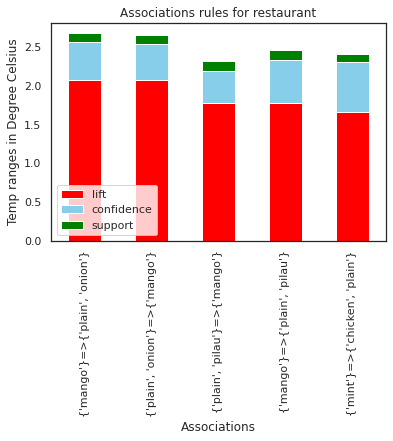

In [59]:
number_rules_to_visualize = 5
rules_top = rules.iloc[0:number_rules_to_visualize, :].loc[:, ["association", "lift", "confidence", "support"]]
rules_top.index = rules_top["association"]
rules_top = rules_top.drop(columns=["association"])

#set seaborn plotting aesthetics
sns.set(style='white')

plt.figure(figsize=(40,70))
# create stacked bar chart for monthly temperatures
rules_top.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'])
 
# labels for x & y axis
plt.xlabel('Associations')
plt.ylabel('Temp ranges in Degree Celsius')
 
# title of plot
plt.title('Associations rules for restaurant')

For each rule:

1. {Plain Papadum} => {Mango Chutney}

Rule#1: If a client buy a Plain Papadum, then the client will buy a Mango Chutney.

-The confidence of the rule is 42% (being the lowest level of confidence of the three rules)

-The lift is > 1, so Mango Chutney is likely to be bought with Plain Papadum, but with support 11%

-Taking to account the popularity of Mango Chutney, the probability that Mango Chutney will be purchased when Plain Papadum is purchased is not as high as the Rule#2 but is higher than Rule#3

2. {Mango Chutney} => {Plain Papadum}

Rule#2: If a client buy a Mango Chutney, then the client will buy a Plain Papadum.

-The confidence of the rule is 73% (being the highest level of confidence of the three rules)

-The lift is > 1, so Plain Papadum is likely to be bought with Mango Chutney, but with support 11%

-Taking to account the popularity of Plain Papadum, the probability that Plain Papadum will be purchased when Mango Chutney is purchased is the highest of the three rules

3. {Plain Naan} => {Pilau Rice}

Rule#3: If a client buy a Plain Naan, then the client will buy a Pilau Rice.

-The confidence of the rule is 46% (higher than the Rule#1 but lower than the Rule#2)

-The lift is > 1, so Pilau Rice is likely to be bought with Plain Naan, but with support 13%

-Taking to account the popularity of Pilau Rice, the probability that Pilau Rice will be purchased when Plain Naan is purchased is the lowest of the three rules

When there are thousand of transactions a very low minimun support is needed. Because throughout the years the menu of the restaurant may changed, so the frequencies of some products will be frozen and the support for each one wil decrease while the transactions increase.
If a client buy a Mango Chutney, then the client will buy a Plain Papadum with a high confidence.
A rule {A} => {B} is different of a rule {B} => {A} but share the same support.
The sparse matrix generated can use a lot of RAM.
The library mlxtend don't use sparse tensors to represent better the data.